In [ ]:
# Sam Maurer, updated 2-25-2015
# Move-out modeling using PUMS data - working code part 4

In [ ]:
''' 2013 ACS 1-years PUMS data

PERSON RECORD 

SERIALNO = household identifier
PUMA = area id, first 3 digits of which are county FIPS
AGEP = age of individual, from 0 to 99
RELP = 00 indicates "reference person", other categories indicate relationship to that person 
PAP = public assistance income, integer
MIGPUMA = migration from other PUMA in last 12m
MIGSP = migration from state or country in last 12m
RAC1P = race code, 1=white, 2=black, 6=asian
HISP = hispanic code, 1=not hispanic

ALL OTHERS FROM HOUSEHOLD RECORD...

TENURE

TEN = tenure, 3 = rented, 1 = owned w/ mortgage, 2 = owned free and clear
MV = when moved into this unit, 1 = 12m or less  

GEOGRAPHY

PUMA = PUMA id, first 3 characters of which is the county FIPS code

DEMOGRAPHIC CHARACTERISTICS

NP = number of persons in household, int  
FES = fam type and employment status, categories  
FPARC = fam presence and age of related children, categories  
HHT = hh type, categories  
HUPAC = hh presence and age of childen, 1/2/3 = children present, 1 = under age 6  
HHL = hh language, 1 english, 2 spanish, 4 asian languages

MONETARY CHARACTERISTICS

RNTP = monthly rent, int or blank  
GRNTP = gross monthly rent, int or blank  
FINCP = fam income past 12m, signed int or blank  
GRPIP = gross rent as pct of hh income past 12m, int percent or blank  
HINCP = hh income past 12m, signed int or blank  

BUILDING CHARACTERISTICS (Paul doesn't like these)

BDSP = number of bedrooms, int or blank  
BLD = units in structure, categories 1 to 10 or blank  
RMSP = number of rooms, int or blank  
YBL = year structure first built, int (sometimes rounded to decade) or blank  
'''

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import csv

In [2]:
bayarea_fips = [1,13,41,55,75,81,85,95,97]

In [3]:
# Load household records for Bay Area

h = []
f = csv.DictReader(open('../data/ss13hca.csv'))

for row in f:
    county = int(row['PUMA'][:3])
    if county in bayarea_fips:
        h.append(row)
        
print len(h)

31068


In [4]:
# Load person records - for heads of household only (aka "reference persons")

p = []
f = csv.DictReader(open('../data/ss13pca.csv'))

for row in f:
    county = int(row['PUMA'][:3])
    householder = (int(row['RELP']) == 0)
    if county in bayarea_fips and householder:
        p.append(row)
        
print len(p)

27340


In [5]:
# Check how the tables are linked - how many "heads" does each household have?

h_serials = np.array([r['SERIALNO'] for r in h])
p_serials = np.array([r['SERIALNO'] for r in p])
head_counts = []

for s in np.unique(h_serials):
    head_counts.append(np.sum(p_serials==s))

print pd.DataFrame(head_counts).describe()

# --> households have zero (12%) or one (88%) head each

                  0
count  31068.000000
mean       0.880005
std        0.324961
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000


In [27]:
# Set up household variables in a dataframe for regressions

def to_np_int(name):
    return np.array([int(r[name]) if r[name]!='' else np.nan for r in h])
    
df = pd.DataFrame({
        'Serial':  np.array([r['SERIALNO'] for r in h]),
        'Renter':  np.array([1*(r['TEN']=='3') for r in h]),
        'Owner':   np.array([1*(r['TEN'] in ('1','2')) for r in h]),
        'Moved':   np.array([1*(r['MV']=='1') for r in h]),
        'Income':  to_np_int('HINCP'),
        'Rent':    to_np_int('RNTP'),
        'Burden':  to_np_int('GRPIP'),
        'Persons': to_np_int('NP'),
        'HhType':  np.array([r['HHT'] for r in h]),
        'Child':   np.array([1*(r['HUPAC'] in ('1','2','3')) for r in h]),
        'YoungChld': np.array([1*(r['HUPAC']=='1') for r in h]),
        'PUMA':    np.array([r['PUMA'] for r in h]),
        'CFIPS':   np.array([r['PUMA'][:3] for r in h]),
        'SanFran': np.array([1*(r['PUMA'][:3]=='075') for r in h])})

print df.head(), '\n'
print df[['Income','Rent','Burden','Persons']].describe(), '\n'  # continuous
print df[['Renter','Owner','Moved','YoungChld','SanFran']].describe(), '\n'  # binary
print df[['Serial','PUMA','CFIPS']].describe()  # categorical

   Burden CFIPS  Child HhType  Income  Moved  Owner   PUMA  Persons  Rent  \
0     NaN   085      0      3   16000      0      1  08503        2   NaN   
1     101   001      0      1    9400      0      0  00102        2   770   
2     NaN   085      0      5  193500      0      1  08501        2   NaN   
3     NaN   055      1      1  224000      0      1  05500        4   NaN   
4     101   013      1      1    8400      0      0  01307        4   750   

   Renter  SanFran Serial  YoungChld  
0       0        0     16          0  
1       1        0     53          0  
2       0        0    141          0  
3       0        0    189          0  
4       1        0    220          0   

               Income          Rent        Burden       Persons
count    27340.000000  10443.000000  10014.000000  31068.000000
mean    116297.048317   1465.893326     38.996804      2.368997
std     116766.800894    725.294564     27.373558      1.567546
min     -11100.000000      4.000000      1.00

In [48]:
# Merge person variables into the households dataframe
# - can you do SQL-style joins on dataframes? would scale better than this code

h_serials = df['Serial']
p_serials = np.array([r['SERIALNO'] for r in p])

def person_to_household(person_array):
    out = []
    for s in h_serials:
        try:
            tmp = person_array[p_serials==s][0]  # should be exactly one match, or none
        except:
            tmp = np.NaN
        out.append(tmp)
    return out

p_age = np.array([int(r['AGEP']) for r in p])
p_assist = np.array([int(r['PAP']) for r in p])
p_assist_dum = np.array([1*(int(r['PAP']) > 0) for r in p])
p_white = np.array([1*(r['RAC1P']=='1')*(r['HISP']=='01') for r in p])
p_hisp = np.array([1*(r['HISP']!='01') for r in p])
p_black = np.array([1*(r['RAC1P']=='2') for r in p])
p_asian = np.array([1*(r['RAC1P']=='6') for r in p])

df['Age'] = person_to_household(p_age)
df['Assist'] = person_to_household(p_assist)
df['Assist_dum'] = person_to_household(p_assist_dum)
df['White'] = person_to_household(p_white)
df['Hisp'] = person_to_household(p_hisp)
df['Black'] = person_to_household(p_black)
df['Asian'] = person_to_household(p_asian)

print df[['Age','Assist','Assist_dum','White','Hisp','Black','Asian']].describe()

                Age        Assist    Assist_dum         White          Hisp  \
count  27340.000000  27340.000000  27340.000000  27340.000000  27340.000000   
mean      52.689612     60.122531      0.013460      0.544257      0.138552   
std       16.583103    726.921536      0.115236      0.498047      0.345484   
min       15.000000      0.000000      0.000000      0.000000      0.000000   
25%       40.000000      0.000000      0.000000      0.000000      0.000000   
50%       52.000000      0.000000      0.000000      1.000000      0.000000   
75%       64.000000      0.000000      0.000000      1.000000      0.000000   
max       94.000000  30000.000000      1.000000      1.000000      1.000000   

              Black         Asian  
count  27340.000000  27340.000000  
mean       0.058778      0.226957  
std        0.235214      0.418872  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


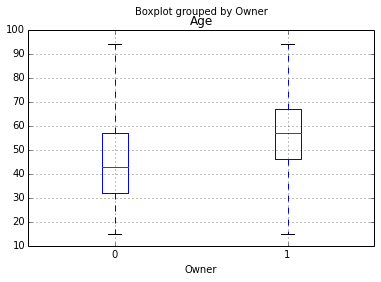

In [47]:
# What are the age ranges for renters vs owners?

df.boxplot('Age', by='Owner')

In [43]:
# Clean up the income fields

# rescale to $1000's for easier interpretation
df['Income_k'] = df['Income']/1000
df['Assist_k'] = df['Assist']/1000

# try a log-income term - need to ignore negative income values
df['Ln_Income'] = np.log(df['Income'].apply(lambda x: np.nan if (x < 1) else x))

print df[['Income','Income_k','Ln_Income','Assist','Assist_k']].describe()

# --> turns out raw income fits better than log income in the models

               Income      Income_k     Ln_Income        Assist      Assist_k
count    27340.000000  27340.000000  27081.000000  27340.000000  27340.000000
mean    116297.048317    116.297048     11.214225     60.122531      0.060123
std     116766.800894    116.766801      1.088303    726.921536      0.726922
min     -11100.000000    -11.100000      0.000000      0.000000      0.000000
25%      40000.000000     40.000000     10.627649      0.000000      0.000000
50%      83700.000000     83.700000     11.348051      0.000000      0.000000
75%     150000.000000    150.000000     11.918391      0.000000      0.000000
max    1307000.000000   1307.000000     14.083245  30000.000000     30.000000


In [34]:
# Basic regression for RENTERS

print 'MOVE-CHOICE MODEL FOR RENTERS \n'
data = df[df['Renter']==1]
res = sm.Logit.from_formula('Moved ~ Income_k + Age + Persons + YoungChld + SanFran', data).fit()
print res.summary()

MOVE-CHOICE MODEL FOR RENTERS 

Optimization terminated successfully.
         Current function value: 0.513863
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Moved   No. Observations:                10168
Model:                          Logit   Df Residuals:                    10162
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 Feb 2015   Pseudo R-squ.:                 0.07668
Time:                        22:49:45   Log-Likelihood:                -5225.0
converged:                       True   LL-Null:                       -5658.9
                                        LLR p-value:                2.467e-185
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.1906      0.096     12.391      0.000         1.002     1.3

In [35]:
# Same basic regression for OWNERS
# -> need to add a cost burden

print 'MOVE-CHOICE MODEL FOR OWNERS \n'
data = df[df['Owner']==1]
res = sm.Logit.from_formula('Moved ~ Income_k + Age + Persons + YoungChld + SanFran', data).fit()
print res.summary()

MOVE-CHOICE MODEL FOR OWNERS 

Optimization terminated successfully.
         Current function value: 0.180713
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Moved   No. Observations:                16821
Model:                          Logit   Df Residuals:                    16815
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 Feb 2015   Pseudo R-squ.:                  0.1053
Time:                        22:50:37   Log-Likelihood:                -3039.8
converged:                       True   LL-Null:                       -3397.7
                                        LLR p-value:                1.796e-152
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0310      0.177      5.830      0.000         0.684     1.37

In [36]:
# Stratify rent burden by income buckets (copied from prior notebook)

breaks = [0, 10, 20, 40, 60, 80, 100, 120, 150, 200, 300]

for i in range(len(breaks)-1):
    name = 'Burden_' + str(breaks[i+1]) + 'k'
    df[name] = df['Burden'] * ((df['Income']<=1000*breaks[i+1]) & (df['Income']>1000*breaks[i]))    
df['Burden_Top'] = df['Burden'] * (df['Income']>1000*breaks[-1])

varlist = ' + '.join(['Burden_' + str(n) + 'k' for n in breaks[1:]]) + ' + Burden_Top'
print varlist

Burden_10k + Burden_20k + Burden_40k + Burden_60k + Burden_80k + Burden_100k + Burden_120k + Burden_150k + Burden_200k + Burden_300k + Burden_Top


In [37]:
# Add burdens to the renter model

print 'MOVE-CHOICE MODEL FOR RENTERS \n'
data = df[df['Renter']==1]
res = sm.Logit.from_formula('Moved ~ ' + varlist + ' + Income_k + Age + Persons + YoungChld + SanFran', data).fit()
print res.summary()

MOVE-CHOICE MODEL FOR RENTERS 

Optimization terminated successfully.
         Current function value: 0.501635
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Moved   No. Observations:                10014
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                           16
Date:                Wed, 25 Feb 2015   Pseudo R-squ.:                 0.09639
Time:                        22:50:46   Log-Likelihood:                -5023.4
converged:                       True   LL-Null:                       -5559.2
                                        LLR p-value:                4.748e-218
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.3246      0.130      2.494      0.013         0.070     

In [40]:
# Add race

print 'MOVE-CHOICE MODEL FOR RENTERS \n'
data = df[df['Renter']==1]
res = sm.Logit.from_formula('Moved ~ ' + varlist + 
        ' + Income_k + Age + Persons + YoungChld + Hisp + Black + Asian + SanFran', data).fit()
print res.summary()

MOVE-CHOICE MODEL FOR RENTERS 

Optimization terminated successfully.
         Current function value: 0.501236
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Moved   No. Observations:                10014
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                           19
Date:                Wed, 25 Feb 2015   Pseudo R-squ.:                 0.09711
Time:                        22:53:05   Log-Likelihood:                -5019.4
converged:                       True   LL-Null:                       -5559.2
                                        LLR p-value:                4.922e-217
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.3143      0.133      2.356      0.018         0.053     

In [50]:
# Add public assistance

print 'MOVE-CHOICE MODEL FOR RENTERS \n'
data = df[df['Renter']==1]
res = sm.Logit.from_formula('Moved ~ ' + varlist + 
        ' + Income_k + Age + Persons + YoungChld + Hisp + Black + Asian' + 
        ' + Assist_k + SanFran', data).fit()
print res.summary()

MOVE-CHOICE MODEL FOR RENTERS 

Optimization terminated successfully.
         Current function value: 0.501232
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Moved   No. Observations:                10014
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                           20
Date:                Wed, 25 Feb 2015   Pseudo R-squ.:                 0.09712
Time:                        23:27:33   Log-Likelihood:                -5019.3
converged:                       True   LL-Null:                       -5559.2
                                        LLR p-value:                3.611e-216
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.3159      0.134      2.365      0.018         0.054     